# Aplicación de herramientas de ML/DL para análisis de defectología de soldaduras ensayadas con gammagrafía industrial

## Implementación en Keras

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

### Se va a usar el dataset "Cats and dogs" de kagle que contiene imágenes de perros y gatos. Acá es donde debería usarse el dataset con las imágenes de los ensayos de gammagrafía digitalizados:

In [5]:
import os, shutil
import tensorflow as tf

In [6]:
# !kaggle competitions download -c dogs-vs-cats
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

68606236/68606236 [==============================] - 3s 0us/step


#### Creación de los directorios. Acá irían los directorios con las imágenes tageadas por tipo de falla

In [7]:

# Directorio con imagenes de entrenamiento de gatos
train_cats_dir = os.path.join(train_dir, 'cats')

# Directorios con imagenes de entrenamiento de perros
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorios con las imagenes de validacion de gatos
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directorios con las imagenes de validacion de perros
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directorios con imagenes de test de gatos
test_cats_dir = os.path.join(test_dir, 'cats')

#### Cantidad de imágenes en cada split:

In [11]:
print('Cantidad de inmágenes de GATOS para entrenamiento:', len(os.listdir(train_cats_dir)))
print('Cantidad de inmágenes de PERROS para entrenamiento:', len(os.listdir(train_dogs_dir)))

Cantidad de inmágenes de GATOS para entrenamiento: 1000
Cantidad de inmágenes de PERROS para entrenamiento: 1000


In [10]:
print('Cantidad de imágenes de GATOS para validación:', len(os.listdir(validation_cats_dir)))
print('Cantidad de imágenes de PERROS para validación:', len(os.listdir(validation_dogs_dir)))

Cantidad de imágenes de GATOS para validación: 500
Cantidad de imágenes de PERROS para validación: 500


#### Construcción de la red:

In [12]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#### Dimensiones de los mapas de features en cada capa:

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 128)      0

In [15]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

### Preprocesamiento de las imágenes:

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Reescalamos todas las imagenes en un factor de 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Directorio target
        train_dir,
        # Reescalamos las imagenes a tamaño 150x150
        target_size=(150, 150),
        batch_size=20,
        # Usamos etiquetas binarias, ya que usamos binary_crossentropy
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Debemos romper el ciclo de iteración del generador de imágenes:

In [17]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


#### Se usarán 5 épocas o instancias de entrenamiento. (Las veces que el modelo "mira" las imágenes). Se usará como métrica la exactitud para predecir (Accuracy)

In [20]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/5


C:\Users\jorge.cotella\AppData\Local\Temp\ipykernel_4860\2640413749.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


50/50 [==============================] - 24s 488ms/step - loss: 0.5620 - acc: 0.6940 - val_loss: 0.6139 - val_acc: 0.6500
Epoch 2/5
50/50 [==============================] - 28s 569ms/step - loss: 0.5630 - acc: 0.7000 - val_loss: 0.5826 - val_acc: 0.6980
Epoch 3/5
50/50 [==============================] - 27s 536ms/step - loss: 0.5384 - acc: 0.7240 - val_loss: 0.5867 - val_acc: 0.6990
Epoch 4/5
50/50 [==============================] - 26s 518ms/step - loss: 0.5344 - acc: 0.7310 - val_loss: 0.5821 - val_acc: 0.6830
Epoch 5/5
50/50 [==============================] - 25s 497ms/step - loss: 0.5226 - acc: 0.7420 - val_loss: 0.5730 - val_acc: 0.7050


#### Guardo el modelo:

In [21]:
model.save('cats_and_dogs_small_1.h5')

#### Grafico la pérdida y accuracy del modelo en la data de entrenamiento y validacion, durante el entrenamiento:

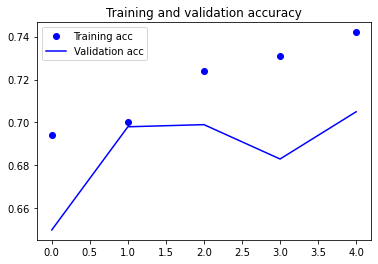

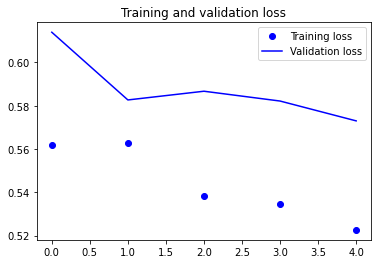

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### El accuracy de train aumenta hasta el 74% aprox. El de validación hasta el 70% y luego se detiene. Nuestra pérdida de validación alcanza un mínimo en torno al 58% en la primer época.